### 1. Import Required Libraries

In [1]:
import os
import re
import email
import pandas as pd
import requests
from email import policy
from email.parser import BytesParser
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import whois
import time

### 2. Parse and Clean Email Content

In [2]:
def parse_email(file_path):
    with open(file_path, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)
    headers = dict(msg.items())
    body = msg.get_body(preferencelist=('plain', 'html'))
    return {
        "subject": headers.get("Subject", ""),
        "from": headers.get("From", ""),
        "to": headers.get("To", ""),
        "received": headers.get("Received", ""),
        "date": headers.get("Date", ""),
        "body": body.get_content() if body else ""
    }

def clean_email_body(raw_html):
    if not raw_html:
        return ""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text(separator=" ", strip=True)

### 3. Extract Metadata from Headers

In [3]:
def extract_info_from_received(received_header):
    ip_match = re.search(r'\[?(\d{1,3}(?:\.\d{1,3}){3})\]?', received_header)
    ip = ip_match.group(1) if ip_match else None
    domain_match = re.search(r'from\s+([\w\.-]+)', received_header, re.IGNORECASE)
    domain = domain_match.group(1) if domain_match else None
    return ip, domain

### 4. Load and Label Emails

In [4]:
def load_emails_from_folder(folder_path, label):
    emails = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            parsed = parse_email(file_path)
            ip, domain = extract_info_from_received(parsed["received"])
            emails.append({
                "from": parsed["from"],
                "subject": parsed["subject"],
                "date": parsed["date"],
                "text": clean_email_body(parsed["body"]),
                "ip": ip,
                "domain": domain,
                "label": label
            })
        except Exception:
            continue
    return emails

ham_emails = load_emails_from_folder("easy_ham", 0)
spam_emails = load_emails_from_folder("spam", 1)
spam2_emails = load_emails_from_folder("spam_2", 1)

all_emails = pd.DataFrame(ham_emails + spam_emails + spam2_emails)
all_emails = all_emails[all_emails['text'].notnull()].copy()

### 5. Prepare Dataset

In [5]:
all_emails["subject"] = all_emails["subject"].fillna("")
all_emails["text"] = all_emails["text"].fillna("")
all_emails["combined_text"] = all_emails["subject"] + " " + all_emails["text"]
all_emails = all_emails.sample(frac=1).reset_index(drop=True)

### 6. Enrich IP Metadata (Geo & Org)

In [6]:
def enrich_ip_metadata(ip):
    if not ip or ip.startswith(("192.", "10.", "127.")):
        return {"country": None, "org": None}
    try:
        r = requests.get(f"http://ip-api.com/json/{ip}", timeout=5)
        if r.status_code == 200:
            data = r.json()
            return {"country": data.get("country"), "org": data.get("org")}
    except:
        pass
    return {"country": None, "org": None}

def is_valid_ip(ip):
    if not isinstance(ip, str):
        return False
    return not (
        ip.startswith("127.") or ip.startswith("10.") or
        ip.startswith("192.168.") or ip.startswith("172.")
    )

valid_spam_ips = all_emails[
    (all_emails['label'] == 1) & (all_emails['ip'].apply(is_valid_ip))
]['ip'].value_counts().head(30)

top_ips = valid_spam_ips.index.tolist()
ip_metadata = {ip: enrich_ip_metadata(ip) for ip in top_ips}

all_emails['country'] = all_emails['ip'].map(lambda ip: ip_metadata.get(ip, {}).get('country'))
all_emails['org'] = all_emails['ip'].map(lambda ip: ip_metadata.get(ip, {}).get('org'))

### 7. Visualize Top IPs and Countries

In [7]:
print("Top 5 Spam IPs (Valid Only):")
print(valid_spam_ips.head(5))

top_countries = all_emails[all_emails['label'] == 1]['country'].value_counts().head(5)
print("\nTop 5 Spam Countries:")
print(top_countries)

top_domains = all_emails[
    (all_emails['label'] == 1) &
    (~all_emails['domain'].isin(["unknown", "mail"])) &
    (all_emails['domain'].notna())
]['domain'].value_counts().head(5)
print("\nTop 5 Spam Domains:")
print(top_domains)

Top 5 Spam IPs (Valid Only):
ip
130.94.4.23        5
217.78.76.138      5
200.57.16.1        4
64.14.243.42       4
209.219.228.247    4
Name: count, dtype: int64

Top 5 Spam Countries:
country
United States    45
China            13
Argentina         5
Mexico            4
Philippines       3
Name: count, dtype: int64

Top 5 Spam Domains:
domain
mx1.mail.yahoo.com    25
hotmail.com           20
smtp-gw-4.msn.com     19
aol.com               18
yahoo.com             17
Name: count, dtype: int64


### 8. Check IPs with VirusTotal

In [8]:
VT_API_KEY = "e98baef21d48f79464a4bd3494609ed97d3d22cf71827be1125ba4271d7d12c6"
def check_ip_virustotal(ip):
    url = f"https://www.virustotal.com/api/v3/ip_addresses/{ip}"
    headers = {"x-apikey": VT_API_KEY}
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            stats = response.json()["data"]["attributes"]["last_analysis_stats"]
            print(f"🔍 IP: {ip}")
            print(f"  Malicious: {stats.get('malicious', 0)}, Suspicious: {stats.get('suspicious', 0)}")
            print(f"  Verdict: {'⚠️ Malicious' if stats.get('malicious', 0) > 0 else '✅ Clean'}")
    except Exception as e:
        print(f"Error checking IP {ip}: {e}")

for ip in top_ips[:5]:
    check_ip_virustotal(ip)
    time.sleep(16)

🔍 IP: 130.94.4.23
  Malicious: 0, Suspicious: 0
  Verdict: ✅ Clean
🔍 IP: 217.78.76.138
  Malicious: 0, Suspicious: 0
  Verdict: ✅ Clean
🔍 IP: 200.57.16.1
  Malicious: 0, Suspicious: 0
  Verdict: ✅ Clean
🔍 IP: 64.14.243.42
  Malicious: 0, Suspicious: 0
  Verdict: ✅ Clean
🔍 IP: 209.219.228.247
  Malicious: 0, Suspicious: 0
  Verdict: ✅ Clean


### 9. WHOIS Lookup for Domains

In [9]:
for domain in top_domains.index.tolist():
    try:
        w = whois.whois(domain)
        print(f"Domain: {domain}, Org: {w.org}, Registrar: {w.registrar}, Created: {w.creation_date}")
    except Exception as e:
        print(f"WHOIS lookup failed for {domain}: {e}")

Domain: mx1.mail.yahoo.com, Org: Yahoo Assets LLC, Registrar: MarkMonitor, Inc., Created: [datetime.datetime(1995, 1, 18, 5, 0), datetime.datetime(1995, 1, 18, 8, 0, tzinfo=datetime.timezone.utc)]
Domain: hotmail.com, Org: Microsoft Corporation, Registrar: MarkMonitor, Inc., Created: [datetime.datetime(1996, 3, 27, 5, 0), datetime.datetime(1996, 3, 27, 5, 0, tzinfo=datetime.timezone.utc)]
Domain: smtp-gw-4.msn.com, Org: Microsoft Corporation, Registrar: MarkMonitor, Inc., Created: [datetime.datetime(1994, 11, 10, 5, 0), datetime.datetime(1994, 11, 10, 5, 0, tzinfo=datetime.timezone.utc)]
Domain: aol.com, Org: AOL Media LLC, Registrar: MarkMonitor, Inc., Created: [datetime.datetime(1995, 6, 22, 4, 0), datetime.datetime(1995, 6, 22, 4, 0, tzinfo=datetime.timezone.utc)]
Domain: yahoo.com, Org: Yahoo Assets LLC, Registrar: MarkMonitor, Inc., Created: [datetime.datetime(1995, 1, 18, 5, 0), datetime.datetime(1995, 1, 18, 8, 0, tzinfo=datetime.timezone.utc)]


### 10. Plot Charts: Spam Sources

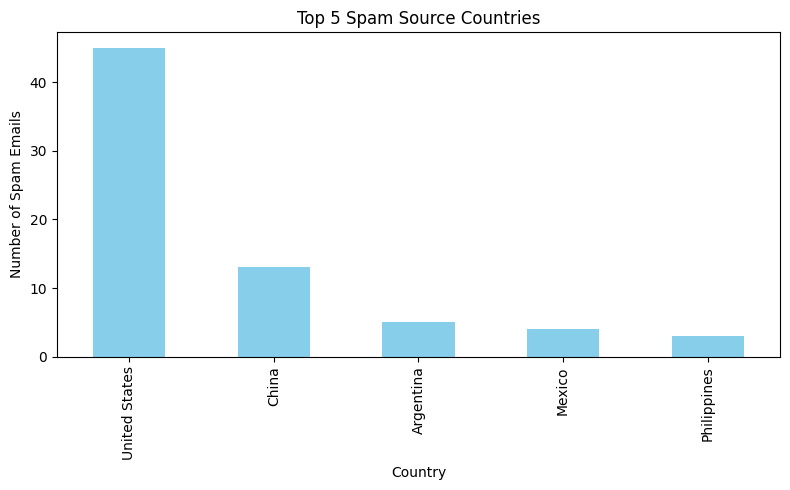

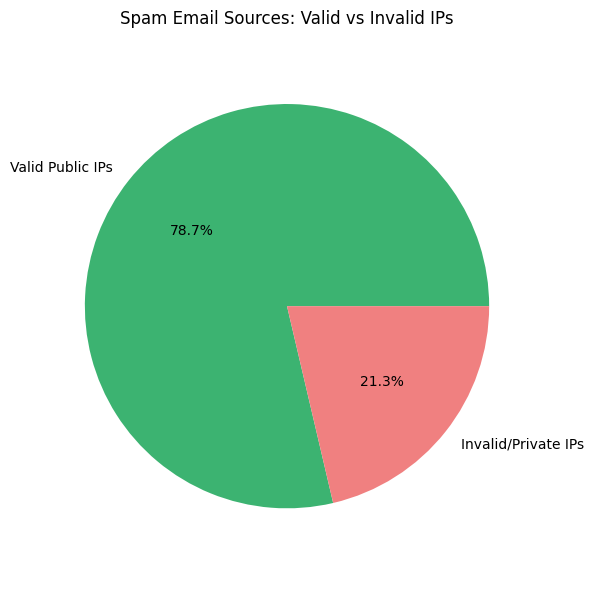

In [10]:
plt.figure(figsize=(8, 5))
top_countries.plot(kind='bar', color='skyblue')
plt.title("Top 5 Spam Source Countries")
plt.xlabel("Country")
plt.ylabel("Number of Spam Emails")
plt.tight_layout()
plt.show()

valid_ip_count = all_emails[(all_emails['label'] == 1) & (all_emails['ip'].apply(is_valid_ip))].shape[0]
invalid_ip_count = all_emails[(all_emails['label'] == 1) & (~all_emails['ip'].apply(is_valid_ip))].shape[0]

plt.figure(figsize=(6, 6))
plt.pie([valid_ip_count, invalid_ip_count], labels=['Valid Public IPs', 'Invalid/Private IPs'],
        autopct='%1.1f%%', colors=['mediumseagreen', 'lightcoral'])
plt.title("Spam Email Sources: Valid vs Invalid IPs")
plt.axis('equal')
plt.tight_layout()
plt.show()

### 11. Categorize Spam Types by Keywords

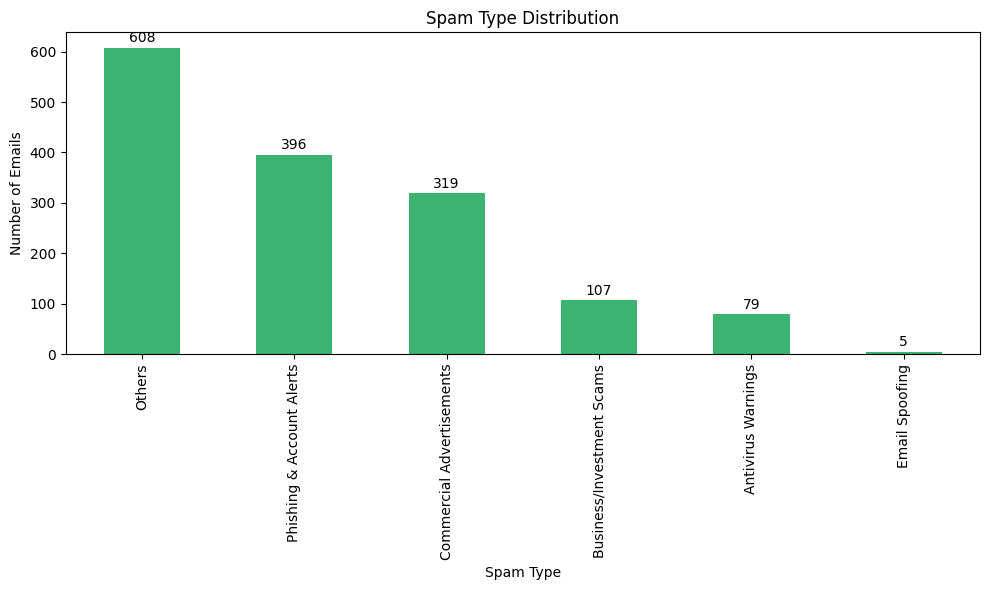

In [11]:
def categorize_spam(text):
    text = text.lower()

    if any(k in text for k in [
        "impersonating", "pretending to be", "fake sender", "spoofed email", 
        "unauthorized email", "not from", "suspicious sender", "identity theft"
    ]):
        return "Email Spoofing"
    
    elif any(k in text for k in [
        "antivirus", "virus", "ransomware", "malware", "spyware", "trojan",
        "infected", "system scan", "security alert", "protection", "clean your pc",
        "your device is", "threats detected", "computer virus", "norton", "symantec"
    ]):
        return "Antivirus Warnings"

    elif any(k in text for k in [
        "buy now", "sale", "discount", "limited time offer", "promotion", 
        "subscribe now", "exclusive deal", "order today", "lowest price", 
        "act fast", "offer expires", "flash sale", "click to save"
    ]):
        return "Commercial Advertisements"
    
    elif any(k in text for k in [
        "account suspended", "login now", "verify account", "click here", 
        "update your details", "reset password", "confirm your information", 
        "unusual activity", "security breach", "your account has been locked"
    ]):
        return "Phishing & Account Alerts"

    elif any(k in text for k in [
        "financial opportunity", "investment", "business proposal", 
        "business relationship", "commissions", "make money", "income opportunity", 
        "quick profit", "urgent partnership", "lucrative deal", "money transfer"
    ]):
        return "Business/Investment Scams"
    
    else:
        return "Others"

all_emails["spam_type"] = all_emails.apply(
    lambda row: categorize_spam(row["text"]) if row["label"] == 1 else None,
    axis=1
)

spam_type_counts = all_emails["spam_type"].value_counts()
plt.figure(figsize=(10,6))
spam_type_counts.plot(kind="bar", color="mediumseagreen")
for i, count in enumerate(spam_type_counts.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')
plt.title("Spam Type Distribution")
plt.xlabel("Spam Type")
plt.ylabel("Number of Emails")
plt.tight_layout()
plt.show()